In [ ]:
import numpy as np
from numba import njit
import numba as nb

In [ ]:
@njit
def internal_mean(arr):
    '''
    same as np.mean(arr, axis=1), but jitted
    since numba does not support kwargs in np.mean
    '''
    assert len(arr.shape) == 3
    assert arr.shape[1] == 2

    out = np.zeros((arr.shape[0], arr.shape[2]), dtype=arr.dtype)
    for i, (v1, v2) in enumerate(arr):
        out[i] = (v1 + v2) / 2

    return out


In [ ]:
from rmsd import kabsch_rotate
from python_functions import rmsd_and_max
from algebra import internal_mean, vec_mean

@njit
def rmsd_and_max_jit(P, Q):
    '''
    ** ADAPTED FROM THE PYTHON RMSD LIBRARY **

    Rotate matrix P unto Q using Kabsch algorithm and calculate the RMSD.
    Returns RMSD and max deviation.

    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Q : array
        (N,D) matrix, where N is points and D is dimension.

    Returns
    -------
    rmsd : float
        root-mean squared deviation
    max_delta : float
        maximum deviation value
    '''

    Q -= vec_mean(Q)
    P -= vec_mean(P)
    P = kabsch_rotate_jit(P, Q)

    diff = Q - P
    rmsd = np.sqrt((diff * diff).sum() / len(diff))
    max_delta = np.max(internal_mean(diff))

    return rmsd, max_delta

@njit
def kabsch_rotate_jit(P, Q):
    # Computation of the covariance matrix
    C = np.dot(np.transpose(P), Q)

    V, S, W = np.linalg.svd(C)
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0

    if d:
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Create Rotation matrix U
    U = np.dot(V, W)

    return np.dot(P, U)


In [ ]:
from algebra import internal_mean

x = np.random.rand(10, 100, 3)
a = np.mean(x, axis=1)
b = internal_mean(x)
np.allclose(a,b)

In [8]:
from cclib.io import ccread
data = ccread(r'C:\Users\ehrma\Desktop\cool_structs\Ph2PAla\Ph2PAla_confs_opt.xyz')
data.atomcoords.shape

(9, 50, 3)

In [16]:
r = [(i,rmsd_and_max(data.atomcoords[0], data.atomcoords[i])) for i in range(len(data.atomcoords))]
r

[(0, (1.8525749981896213e-15, 3.4967619351230766e-15)),
 (1, (1.9522309294727476, 4.349269692010169)),
 (2, (1.950567457203451, 4.293812257739693)),
 (3, (1.3926570564185698, 4.3814557682398325)),
 (4, (1.4772331398625664, 4.305962040648202)),
 (5, (2.8575661817906037, 6.973886368538465)),
 (6, (3.5039995314367505, 7.149551801218124)),
 (7, (3.496796142112092, 7.1505970015359175)),
 (8, (3.4875753074003564, 8.969396529698514))]

In [18]:
print(f'keep {len([i for i in r if i[1][0] < 2])}/{len(r)}')

keep 5/9


In [22]:
from algebra import get_inertia_moments
from pt import pt
masses = np.array([pt[i].mass for i in data.atomnos])
r = [(i,get_inertia_moments(data.atomcoords[i], masses)) for i in range(len(data.atomcoords))]
r

[(0, array([2133.87886433, 4033.85175728, 4519.79219749])),
 (1, array([2108.10440921, 4100.0883652 , 4535.74187787])),
 (2, array([2133.75099027, 4017.2711705 , 4526.16978017])),
 (3, array([2082.10778038, 4160.35064935, 4540.05084272])),
 (4, array([2141.39031201, 3977.88204333, 4476.87732763])),
 (5, array([1902.57193096, 3745.32947845, 4970.9630804 ])),
 (6, array([1892.41180564, 3724.92135472, 4572.62959953])),
 (7, array([1909.48511256, 3702.47426642, 4564.52247149])),
 (8, array([1902.47378844, 3708.48279848, 4566.06758285]))]

In [29]:
[(i,np.max(np.abs(a[1]-r[0][1]))) for i,a in enumerate(r)]

[(0, 0.0),
 (1, 66.23660791267548),
 (2, 16.580586783055423),
 (3, 126.49889206717262),
 (4, 55.96971395089031),
 (5, 451.17088291074197),
 (6, 308.93040256764334),
 (7, 331.3774908658006),
 (8, 325.3689588073248)]

In [32]:
from algebra import center_of_mass
def MOI(coords, masses):
    coords -= center_of_mass(coords, masses)
    return np.sum([masses[i]*np.linalg.norm(coords[i])**2 for i in range(len(coords))])

MOI(data.atomcoords[0], masses)

5343.761409555133

In [33]:
r = [(i,MOI(data.atomcoords[i], masses)) for i in range(len(data.atomcoords))]
[(i,np.max(np.abs(a[1]-r[0][1]))) for i,a in enumerate(r)]

[(0, 0.0),
 (1, 28.205916583229737),
 (2, 5.165439083692945),
 (3, 47.49322667178694),
 (4, 45.68656807037496),
 (5, 34.329164649966515),
 (6, 248.78002961179027),
 (7, 255.52048432172978),
 (8, 255.2493246734457)]

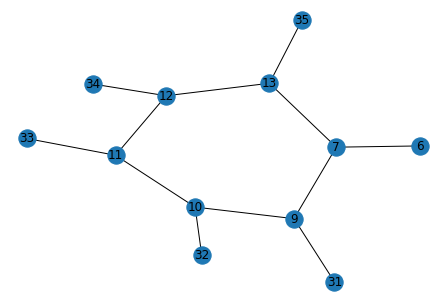

In [1]:
import networkx as nx
edges = [(7, 7), (7, 9), (7, 13), (7, 6), (9, 9), (9, 10), (9, 31), (10, 10), (10, 11), (10, 32), (11, 11), (11, 12), (11, 33), (12, 12), (12, 13), (12, 34), (13, 13), (13, 35), (31, 31), (32, 32), (33, 33), (34, 34), (35, 35)]
G = nx.Graph(edges)
nx.draw(G, with_labels=True)

In [25]:
d = {}
for i in (31,32,33,34,35):
    d[i] = 1
for i in (7,9,10,11,12,13):
    d[i] = 6
d[6] = 15
d[345] = 45
nx.set_node_attributes(G, d, 'atomnos')
# G.nodes[6]['atomnos']
nx.get_node_attributes(G, 'atomnos')

{7: 6,
 9: 6,
 13: 6,
 6: 15,
 10: 6,
 31: 1,
 11: 6,
 32: 1,
 12: 6,
 33: 1,
 34: 1,
 35: 1}

In [3]:
import os
os.chdir(r'C:\Users\ehrma\Desktop\Coding\TSCoDe')
from graph_manipulations import get_sp_n
for node in G.nodes:
    print(f'{node}: sp{get_sp_n(node, G)}')

ValueError: list.remove(x): x not in list